<a href="https://colab.research.google.com/github/Android998/TensorFlow2.3/blob/master/TFG6.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Paso 1: Importar las librerias**

In [25]:
import os
import zipfile
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2')
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

## **Paso 2:Pre procesado de datos**

In [26]:
drive.mount("/content/drive")
base_dir = "./drive/My Drive/object_photos2.0"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
IMAGE_SIZE = 224
BATCH_SIZE = 8
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)


In [28]:
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

print(len(train_generator))

Found 12801 images belonging to 40 classes.
1601


In [29]:
val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')
print(len(val_generator))

Found 3200 images belonging to 40 classes.
400


In [30]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 40))

### **Generamos el archivo labels con las etiquetas de los objetos**

In [31]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'backpack': 0, 'bed': 1, 'belt': 2, 'blind stick': 3, 'bottle': 4, 'carpet': 5, 'cellular phone': 6, 'chair': 7, 'cup-glass': 8, 'door': 9, 'eyeglasses': 10, 'fan': 11, 'handkerchief': 12, 'headphones': 13, 'keys': 14, 'laptop': 15, 'mouse': 16, 'newspaper': 17, 'notebook': 18, 'pen': 19, 'pencil': 20, 'pillow': 21, 'plate': 22, 'plug': 23, 'printer': 24, 'radiator': 25, 'remote control': 26, 'shoes': 27, 'shorts': 28, 'socks': 29, 't-shirts': 30, 'table': 31, 'television': 32, 'toothbrush': 33, 'towel': 34, 'trash bin': 35, 'wallet': 36, 'wardrobe': 37, 'watch': 38, 'window (shade)': 39}


## **Paso 3: Crear el modelo base ya entrenado**

In [32]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.NASNetMobile(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [33]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

### **Añadir ultima capa**

In [34]:
base_model.trainable = False

In [35]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(40, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          608320    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2600      
Total params: 4,880,636
Trainable params: 610,920
Non-trainable params: 4,269,716
_________________________________________________________________


### **Compilar y entrenar el modelo**

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [38]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 10, mode = "auto",
    restore_best_weights = True
)

In [39]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 106s 66ms/step - loss: 1.4581 - accuracy: 0.6171 - val_loss: 1.0251 - val_accuracy: 0.7206
Epoch 2/1000
1601/1601 [==============================] - 102s 63ms/step - loss: 0.8400 - accuracy: 0.7592 - val_loss: 0.9856 - val_accuracy: 0.7366
Epoch 3/1000
1601/1601 [==============================] - 99s 62ms/step - loss: 0.6563 - accuracy: 0.8091 - val_loss: 0.9296 - val_accuracy: 0.7531
Epoch 4/1000
1601/1601 [==============================] - 98s 61ms/step - loss: 0.5178 - accuracy: 0.8418 - val_loss: 0.9719 - val_accuracy: 0.7441
Epoch 5/1000
1601/1601 [==============================] - 97s 61ms/step - loss: 0.4205 - accuracy: 0.8742 - val_loss: 0.9474 - val_accuracy: 0.7450
Epoch 6/1000
1601/1601 [==============================] - 97s 60ms/step - loss: 0.3432 - accuracy: 0.8955 - val_loss: 0.9568 - val_accuracy: 0.7475
Epoch 7/1000
1601/1601 [==============================] - 97s 61ms/step - loss: 0.2819 - accuracy: 0.9126 - va

### **Evaluar el modelo**

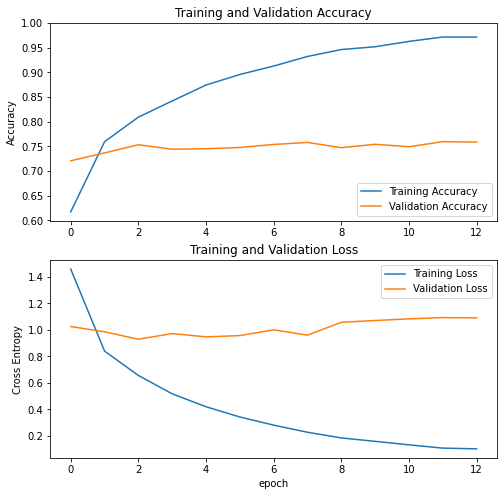

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Paso 4: Fine Tuning**

In [41]:
base_model.trainable = True

In [42]:
print("Number of layersin the base model: {}".format(len(base_model.layers)))

Number of layersin the base model: 769


In [43]:
fine_tune_at = 100

In [44]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### **Compilar y entrenar el modelo**

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001), loss="categorical_crossentropy", metrics=["accuracy"])

In [49]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 172s 108ms/step - loss: 0.2442 - accuracy: 0.9281 - val_loss: 0.8377 - val_accuracy: 0.8003
Epoch 2/1000
1601/1601 [==============================] - 171s 107ms/step - loss: 0.2736 - accuracy: 0.9184 - val_loss: 0.7503 - val_accuracy: 0.8206
Epoch 3/1000
1601/1601 [==============================] - 169s 105ms/step - loss: 0.2720 - accuracy: 0.9188 - val_loss: 0.7172 - val_accuracy: 0.8303
Epoch 4/1000
1601/1601 [==============================] - 168s 105ms/step - loss: 0.2755 - accuracy: 0.9188 - val_loss: 0.7033 - val_accuracy: 0.8309
Epoch 5/1000
1601/1601 [==============================] - 167s 104ms/step - loss: 0.2539 - accuracy: 0.9259 - val_loss: 0.6964 - val_accuracy: 0.8334
Epoch 6/1000
1601/1601 [==============================] - 166s 104ms/step - loss: 0.2634 - accuracy: 0.9207 - val_loss: 0.6915 - val_accuracy: 0.8331
Epoch 7/1000
1601/1601 [==============================] - 164s 103ms/step - loss: 0.2565 - accuracy:

### **Evaluacion de resultados**

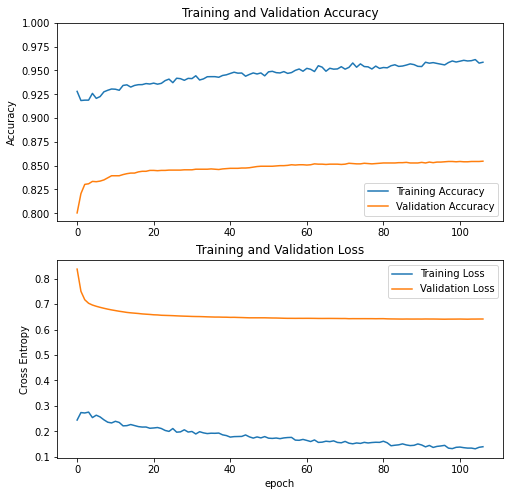

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Seguimos entrenando ya que aun hay margen de mejora**

In [ ]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000001), loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 163s 102ms/step - loss: 0.1430 - accuracy: 0.9566 - val_loss: 0.6417 - val_accuracy: 0.8541
Epoch 2/1000
1601/1601 [==============================] - 160s 100ms/step - loss: 0.1301 - accuracy: 0.9608 - val_loss: 0.6392 - val_accuracy: 0.8556
Epoch 3/1000
1601/1601 [==============================] - 160s 100ms/step - loss: 0.1337 - accuracy: 0.9599 - val_loss: 0.6392 - val_accuracy: 0.8547
Epoch 4/1000
1601/1601 [==============================] - 159s 99ms/step - loss: 0.1263 - accuracy: 0.9626 - val_loss: 0.6398 - val_accuracy: 0.8553
Epoch 5/1000
1601/1601 [==============================] - 160s 100ms/step - loss: 0.1155 - accuracy: 0.9655 - val_loss: 0.6406 - val_accuracy: 0.8553
Epoch 6/1000
1601/1601 [==============================] - 160s 100ms/step - loss: 0.1173 - accuracy: 0.9643 - val_loss: 0.6403 - val_accuracy: 0.8559
Epoch 7/1000
1601/1601 [==============================] - 159s 99ms/step - loss: 0.1133 - accuracy: 0

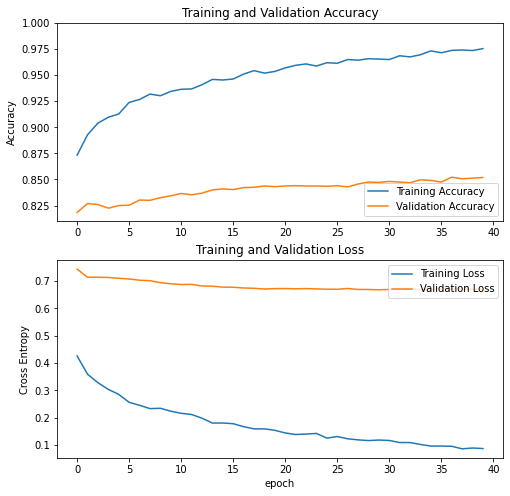

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
fine_tune_at = 0
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0000001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=1000,
                    callbacks = [callback], 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/1000
1601/1601 [==============================] - 238s 149ms/step - loss: 0.1636 - accuracy: 0.9510 - val_loss: 0.6596 - val_accuracy: 0.8525
Epoch 2/1000
1601/1601 [==============================] - 237s 148ms/step - loss: 0.1684 - accuracy: 0.9493 - val_loss: 0.6593 - val_accuracy: 0.8459
Epoch 3/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1649 - accuracy: 0.9494 - val_loss: 0.6608 - val_accuracy: 0.8475
Epoch 4/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1623 - accuracy: 0.9495 - val_loss: 0.6629 - val_accuracy: 0.8484
Epoch 5/1000
1601/1601 [==============================] - 235s 147ms/step - loss: 0.1602 - accuracy: 0.9525 - val_loss: 0.6668 - val_accuracy: 0.8472
Epoch 6/1000
1601/1601 [==============================] - 233s 146ms/step - loss: 0.1646 - accuracy: 0.9497 - val_loss: 0.6722 - val_accuracy: 0.8475
Epoch 7/1000
1601/1601 [==============================] - 231s 144ms/step - loss: 0.1611 - accuracy:

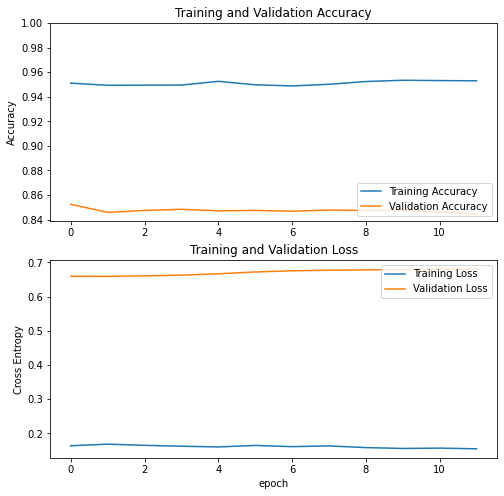

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### **Cargar el modelo de TFLite**

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>